# Income Classifier

This dataset was extracted from the 1994 Census bureau(US) database by Ronny Kohavi and Barry Becker (Dataset available on UCI repository and Kaggle). The prediction task is to determine whether a person makes or not over $US 50.000 a year.

Since data preprocessing and feature engineering are a crucial part in any machine learning project, we will address this by exploring six different encoding techniques along with three feature selection strategies. This combinations will be explored in 4 different models (Logistic regression, SVM classifier, Random Forest & XGBoost), and the whole process will be done taking adventage of pipelines and columntransformers to prevent data leakage, automate the data manipulation and structure the analysis.

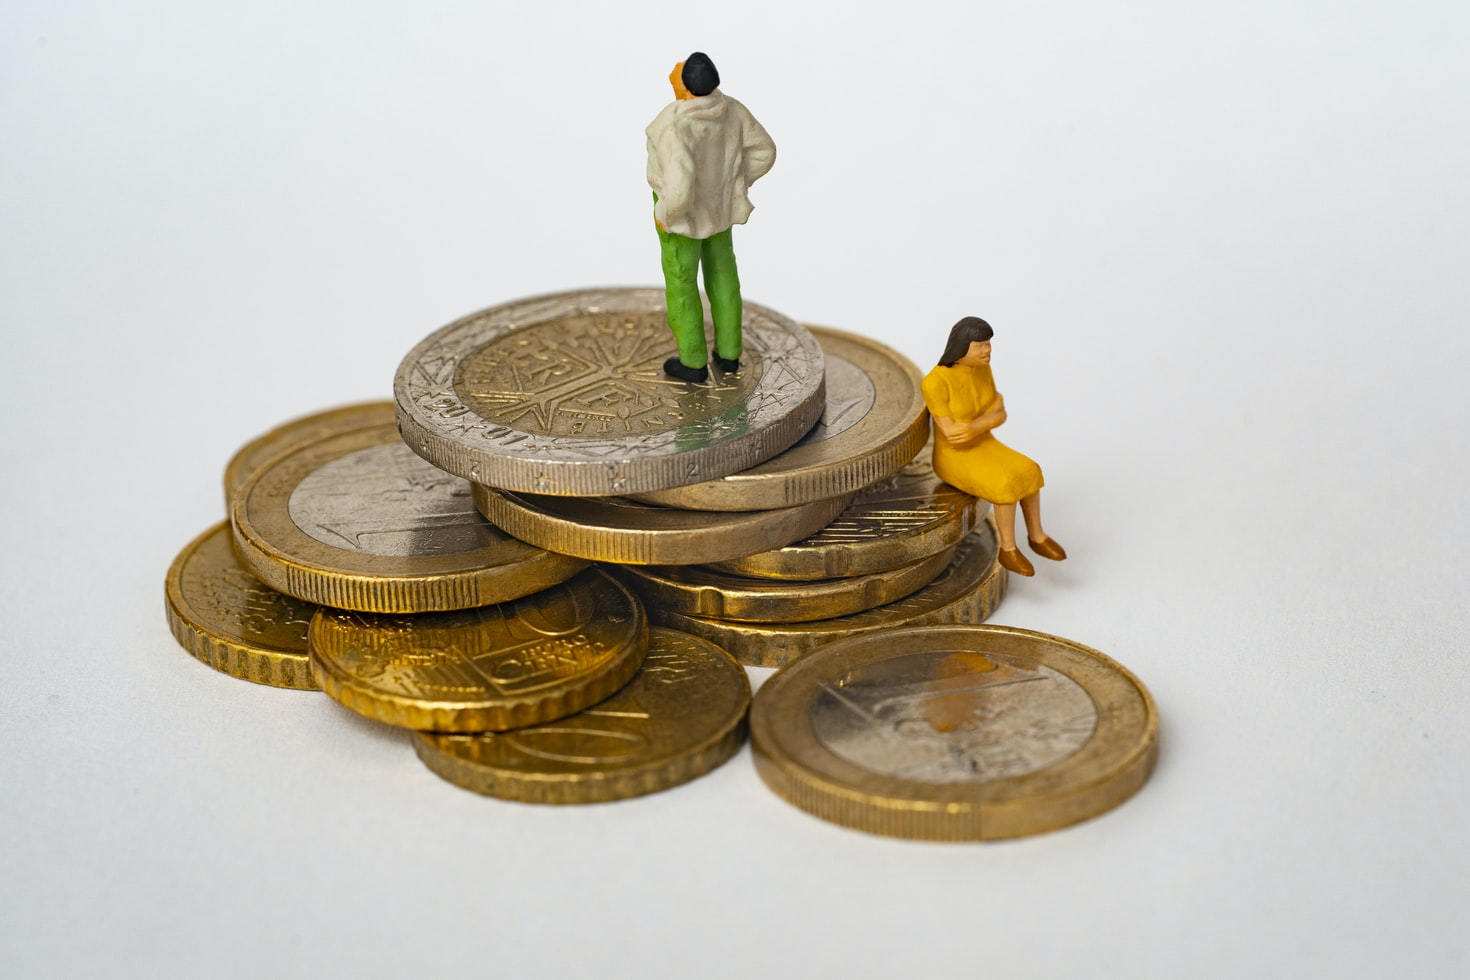

## Table of Contents

1. [Load and check data](#1.Load-&-check-the-data)
2. [Filling in the missing data](#2.Impute-missing-data)
3. [Splitting the dataset](#3.Splitting-the-dataset)
4. [EDA](#4.EDA)<br>
    4.1 [Numerical Features](#4.1-Numerical-Features)<br>
    4.2 [Categorical Features](#4.2-Categorical-Features)
5. [Feature Engineering](#5.Feature-Engineering)<br>
    5.1 [Base Feature Engineering](#5.1-Base-Feature-Engineering)<br>
    5.2 [Pipeline structure](#5.2-Pipeline-structure)<br>
    5.3 [Testing Classifier-Encoder combinations](#5.3-Testing-Classifier-Encoder-combinations)<br>
    5.4 [Feature Selection](#5.4-Feature-Selection)<br>
6. [Training & Hyperparameters Optimization (HPO)](#6.Training-&-Hyperparameters-Optimization-(HPO))<br>
    6.1 [Logistic Regression Classifier](#6.1-Logistic-Regression-Classifier)<br>
    6.2 [SVM Classifier](#6.2-SVM-Classifier-(linear))<br>
    6.3 [Random Forest Classifier](#6.3-Random-Forest-Classifier)<br>
    6.4 [XGBoost Classifier](#6.4-XGBoost-Classifier)<br>
    6.5 [Final Models Pipelines](#6.5-Final-Models-Pipelines)<br>
    6.6 [Soft-Voting Classifier](#6.6-Soft-Voting-Classifier)<br>
7. [Results](#7.Results)<br>
    7.1 [Classifiers Acuraccy Score](#7.1-Classifiers-Acuraccy-Score)<br>
    7.2 [ROC AUC](#7.2-ROC-AUC)<br>
8. [Conclusions](#8.-Conclusions)<br>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", None)

# 1.Load & check the data

In [3]:
census = pd.read_csv('adult.csv')
pd.set_option('display.max_columns', None)

In [4]:
census.shape

(32561, 15)

In [5]:
census.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [6]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Apparently there are no null values, although when we take a closer look we notice that some instances have '?' instead of valid data. Since we have few columns, we can make a visual inspection over the categorical variables (numerical variables seem to have no missing or data type problem).

In [7]:
for col in census.select_dtypes(include='object').columns:
    print('-->',col,':',pd.unique(census[col]))

--> workclass : ['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']
--> education : ['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']
--> marital.status : ['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']
--> occupation : ['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service' 'Adm-clerical' 'Craft-repair' 'Transport-moving'
 'Handlers-cleaners' 'Sales' 'Farming-fishing' 'Tech-support'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
--> relationship : ['Not-in-family' 'Unmarried' 'Own-child' 'Other-relative' 'Husband' 'Wife']
--> race : ['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
--> sex : ['Female' 'Male']
--> native.country : ['United-States' '?' 'Mexico' 'Greece' 'Vietnam' 'China' 'Ta

All the values but '?' seem normal, so let's transform them into manipulable missing data

In [8]:
census = census.replace('?', np.nan)

In [9]:
census.isna().sum()[census.isna().sum()!=0]

workclass         1836
occupation        1843
native.country     583
dtype: int64

In [10]:
(census.isna().sum()/census.count())[['workclass','occupation','native.country']].round(3)

workclass         0.060
occupation        0.060
native.country    0.018
dtype: float64

# 2.Impute missing data

In [11]:
sns.set_theme(context='notebook',style='darkgrid',palette='icefire')

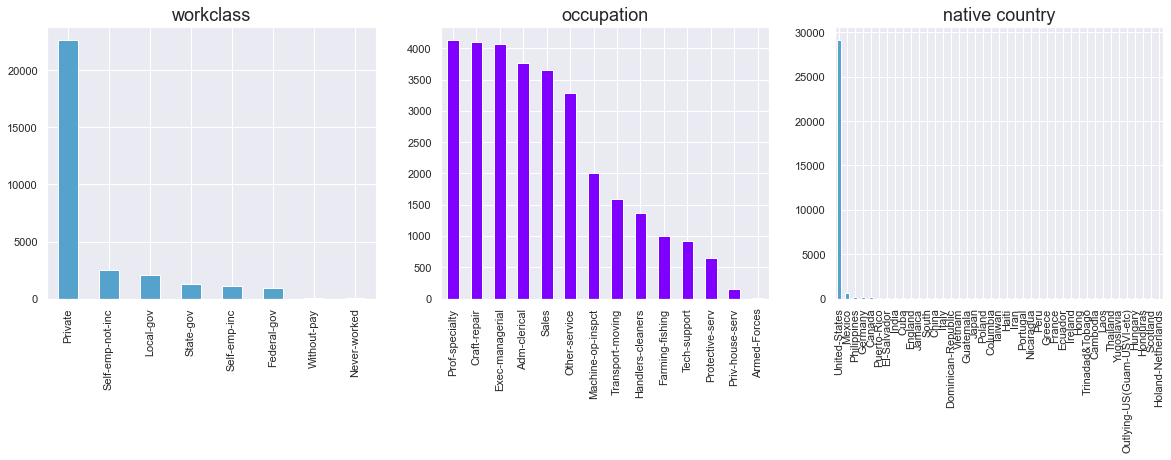

In [12]:
f, ax = plt.subplots(1,3,figsize=(20,5))

census.groupby('workclass').count().iloc[:,0].sort_values(ascending=False).plot(kind='bar', ax=ax[0],xlabel='');
census.groupby('occupation').count().iloc[:,0].sort_values(ascending=False).plot(kind='bar', ax=ax[1],xlabel='',colormap='rainbow');
census.groupby('native.country').count().iloc[:,0].sort_values(ascending=False).plot(kind='bar', ax=ax[2],xlabel='');

ax[0].set_title('workclass',fontsize=18)
ax[1].set_title('occupation',fontsize=18)
ax[2].set_title('native country',fontsize=18);

### Workclass & native.country

As we can observe, in the case of workclass and native country there is a clearly predominant category over the rest, so we proceed to impute the missing data with the corresponding mode.

In [13]:
mode_ser = census[['workclass', 'native.country']].mode().T.iloc[:,0]
census[['workclass', 'native.country']]=census[['workclass', 'native.country']].fillna(mode_ser)

### Occupation

Now, to impute occupation we will use the mode as well, but in this case we will distinguish between subgroups depending on their educational level and sex. But before doing so, let's group educational data of people that haven't finished High School.

In [14]:
undergrad = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th']

census['education2']=census.apply(lambda x: 'HS-undergrad' if x['education'] in undergrad else x['education'], axis=1)
pd.pivot_table(data=census, index='occupation',columns=['education2','sex'],values='age',aggfunc='count',margins=True)

education2        Assoc-acdm        Assoc-voc        Bachelors          \
sex                   Female   Male    Female   Male    Female    Male   
occupation                                                               
Adm-clerical           133.0   60.0     125.0   42.0     267.0   239.0   
Armed-Forces             NaN    NaN       NaN    NaN       NaN     1.0   
Craft-repair             7.0  108.0      13.0  239.0      14.0   212.0   
Exec-managerial         57.0   88.0      53.0   97.0     332.0  1037.0   
Farming-fishing          1.0   13.0       2.0   50.0       3.0    74.0   
Handlers-cleaners        1.0   23.0       5.0   23.0       4.0    46.0   
Machine-op-inspct        7.0   26.0      10.0   53.0      14.0    55.0   
Other-service           47.0   31.0      64.0   51.0      80.0   101.0   
Priv-house-serv          2.0    NaN       3.0    1.0       5.0     2.0   
Prof-specialty          73.0   65.0      94.0   76.0     579.0   916.0   
Protective-serv          1.0   33.0       6.0   42.0      14.0    86.0   
Sales                   43.0  101.0      30.0   76.0     163.0   646.0   
Tech-support            25.0   48.0      54.0   72.0      75.0   155.0   
Transport-moving         4.0   23.0       2.0   38.0       2.0    60.0   
All                    401.0  619.0     461.0  860.0    1552.0  3630.0   

education2        Doctorate        HS-grad         HS-undergrad          \
sex                  Female   Male  Female    Male       Female    Male   
occupation                                                                
Adm-clerical            1.0    4.0   968.0   397.0        109.0    67.0   
Armed-Forces            NaN    NaN     NaN     4.0          NaN     1.0   
Craft-repair            1.0    1.0   102.0  1820.0         34.0   651.0   
Exec-managerial        12.0   43.0   266.0   541.0         28.0    80.0   
Farming-fishing         NaN    1.0    21.0   383.0         17.0   241.0   
Handlers-cleaners       NaN    NaN    89.0   522.0         38.0   347.0   
Machine-op-inspct       1.0    NaN   271.0   752.0        173.0   321.0   
Other-service           NaN    1.0   725.0   556.0        437.0   398.0   
Priv-house-serv         NaN    NaN    49.0     1.0         65.0     4.0   
Prof-specialty         68.0  253.0   100.0   133.0         21.0    36.0   
Protective-serv         NaN    NaN    22.0   193.0          6.0    28.0   
Sales                   1.0    7.0   422.0   647.0        192.0   161.0   
Tech-support            1.0    2.0    58.0   101.0          9.0    11.0   
Transport-moving        NaN    1.0    51.0   774.0         10.0   336.0   
All                    85.0  313.0  3144.0  6824.0       1139.0  2682.0   

education2        Masters         Prof-school        Some-college          \
sex                Female    Male      Female   Male       Female    Male   
occupation                                                                  
Adm-clerical         29.0    39.0         2.0    7.0        903.0   378.0   
Armed-Forces          NaN     1.0         NaN    NaN          NaN     2.0   
Craft-repair          2.0    20.0         NaN    7.0         49.0   819.0   
Exec-managerial     108.0   393.0         8.0   44.0        295.0   584.0   
Farming-fishing       NaN    10.0         NaN    4.0         21.0   153.0   
Handlers-cleaners     NaN     5.0         NaN    NaN         27.0   240.0   
Machine-op-inspct     2.0     6.0         NaN    1.0         72.0   238.0   
Other-service        12.0     7.0         1.0    3.0        434.0   347.0   
Priv-house-serv       1.0     NaN         NaN    NaN         16.0     NaN   
Prof-specialty      337.0   507.0        72.0  380.0        171.0   259.0   
Protective-serv       NaN    15.0         NaN    1.0         27.0   175.0   
Sales                21.0   113.0         4.0   14.0        387.0   622.0   
Tech-support          8.0    29.0         2.0    5.0        116.0   157.0   
Transport-moving      NaN    10.0         NaN    3.0         21.0   262.0   
All    

Now we can impute the data depending on the mode of each subgroup

In [15]:
def mode_imp(occ,sex,ed,ser):
    for i in range(ser.size):
        if (sex,ed) == ser.index[i]:
            return ser[i]

In [16]:
mode_series = census.groupby(['sex','education2'])['occupation'].agg(pd.Series.mode)
census['occupation']=census.apply(lambda x: mode_imp(x['sex'],x['sex'],x['education2'],mode_series) if pd.isna(x['occupation']) else x['occupation']
             , axis=1)
census.drop('education2', axis=1, inplace=True)

# 3.Splitting the dataset

Before exploring the dataset, we need to set aside the part of the data we want to use to test our model, this way we are avoiding the snooping bias

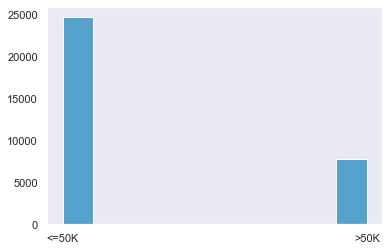

In [17]:
census['income'].hist(grid=False);

In [18]:
census['income'].value_counts(normalize=True)

<=50K    0.75919
>50K     0.24081
Name: income, dtype: float64

Our dataset is imbalanced, where instances with a salary under 50k is almost 75% of the observations. Therefore, we proceed to split the dataset using a stratified method, but before doing so lets encode our target feature according to:
* 0: <=50k
* 1: >50k

In [19]:
target_enco = pd.Series({'<=50K':0,'>50K':1})
census['income'] = census['income'].map(target_enco)

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=1405)  # set aside 40% for test set 

for train_idx, test_idx in sss.split(census, census['income']):
    test = census.loc[test_idx]
    train = census.loc[train_idx]

In [21]:
train['income'].value_counts(normalize=True)

0    0.759214
1    0.240786
Name: income, dtype: float64

In [22]:
test['income'].value_counts(normalize=True)

0    0.759155
1    0.240845
Name: income, dtype: float64

Now we have train & test datasets with an equivalent income category proportion, let's proceed to the exploratory data analysis

# 4.EDA

## 4.1 Numerical Features

In [23]:
num_feat = train.iloc[:,:-1].select_dtypes(exclude=object).columns

In [24]:
train.describe().round(1)

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income
count,19536.0,19536.0,19536.0,19536.0,19536.0,19536.0,19536.0
mean,38.7,189928.6,10.1,1059.4,86.5,40.4,0.2
std,13.6,106171.0,2.6,7279.7,399.8,12.4,0.4
min,17.0,12285.0,1.0,0.0,0.0,1.0,0.0
25%,28.0,117767.0,9.0,0.0,0.0,40.0,0.0
50%,37.0,178218.5,10.0,0.0,0.0,40.0,0.0
75%,48.0,237293.2,12.0,0.0,0.0,45.0,0.0
max,90.0,1484705.0,16.0,99999.0,4356.0,99.0,1.0


There is little correlation with income, the one that has the highest correlation is education.num followed by age and hours per week

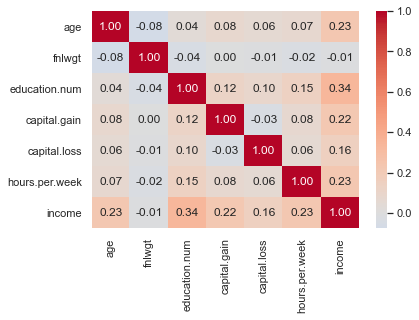

In [25]:
sns.heatmap(train.corr(),annot=True,center=0, fmt='.2f',cmap='coolwarm');

When we look at the boxplots we can appreciate the correlation trend, where higher age, education.num and hours per week tend to belong to the higher salary class

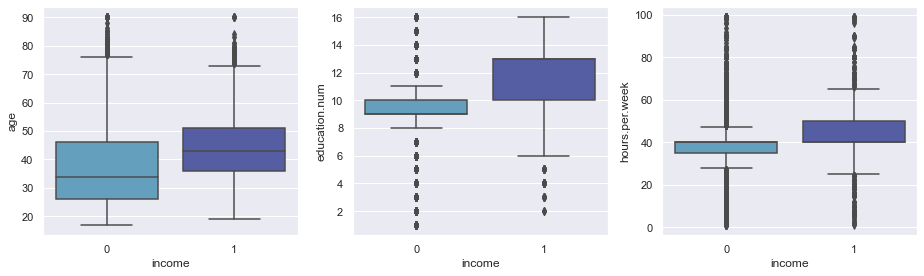

In [26]:
f, ax = plt.subplots(1,3,figsize=(13,4))

sns.boxplot(data=train, y='age', x='income', ax=ax[0])
sns.boxplot(data=train, y='education.num', x='income', ax=ax[1])
sns.boxplot(data=train, y='hours.per.week', x='income', ax=ax[2])

plt.tight_layout()

Also we can explore each feature using individual plots of the mean income for each inner category (and the corresponding ci generated via bootstrap by seaborn). This shows a clearer relationship between income and **education.num**, besides it shows a mean income **peak around 50 years** with a larger c.interval over 60 years. Finally, **hours.per.week** has an ascending trend but with high variability and high ci from 60 hours and beyond.

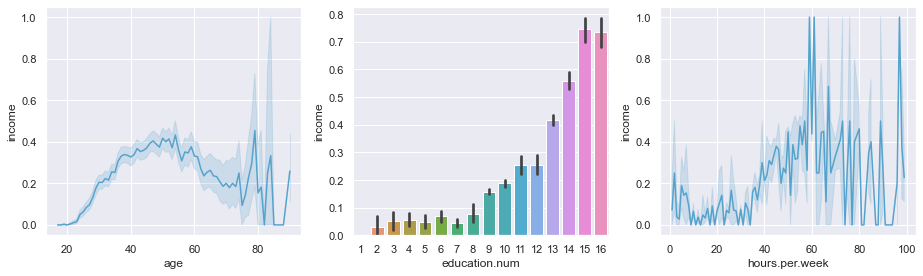

In [27]:
f, ax = plt.subplots(1,3,figsize=(13,4))
sns.lineplot(data=train, x='age',y='income',ax=ax[0])
sns.barplot(data=train, x='education.num',y='income',ax=ax[1])
sns.lineplot(data=train, x='hours.per.week',y='income',ax=ax[2])

plt.tight_layout()

Now, let's check how the data is distributed within each category 

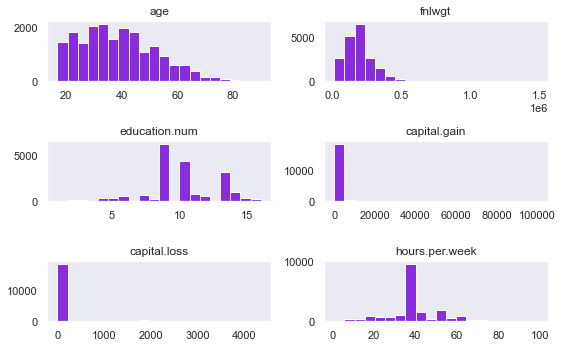

In [28]:
train.loc[:,num_feat].hist(grid=False, bins=20,figsize=(8,5),color='blueviolet')
plt.tight_layout();

In [29]:
print(f'Train_df len: {train.shape[0]}')
print(f'Non cero capital.loss: {train[train["capital.loss"]!=0].count()[0]}  {train[train["capital.loss"]!=0].count()[0]/train.shape[0]*100:0.2f}%')
print(f'Non cero capital.gain: {train[train["capital.gain"]!=0].count()[0]}  {train[train["capital.gain"]!=0].count()[0]/train.shape[0]*100:0.2f}%')

Train_df len: 19536
Non cero capital.loss: 910  4.66%
Non cero capital.gain: 1595  8.16%


Most of the capital gains and losses data are 0s, but capital.gain seems to convey a higher salary for non 0s. The rest of the features look fairly symmetric, with age and fnlwgt right skewed (0.5 rule of thumb for moderate skewness).

In [30]:
train.skew()[['age','fnlwgt']]

age       0.554728
fnlwgt    1.470112
dtype: float64

## 4.2 Categorical Features

In [31]:
cat_feat = train.select_dtypes(include=object).columns

In [32]:
train.describe(include=object)

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,19536,19536,19536,19536,19536,19536,19536,19536
unique,8,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
freq,14699,6310,8976,2955,7932,16694,13096,17844


First of all, we are using countplots to know the size of each group within the categories

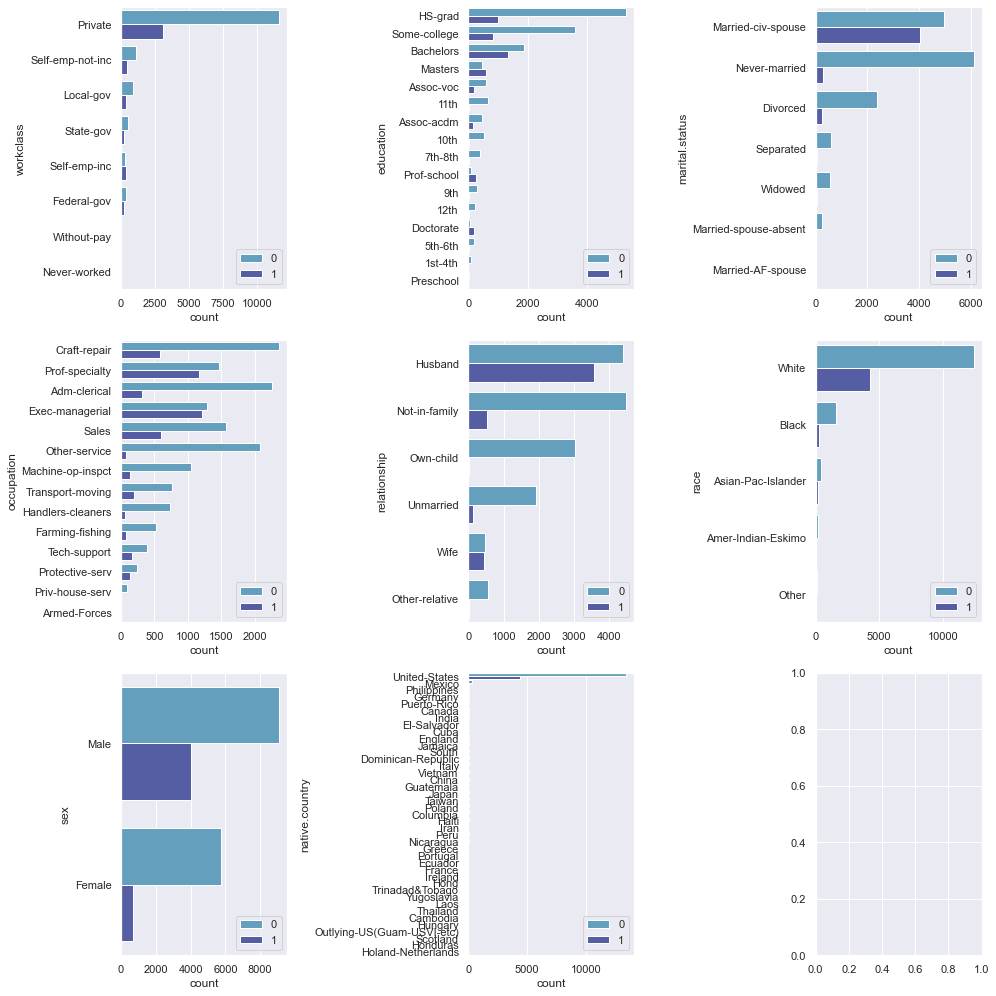

In [33]:
import math
f,ax = plt.subplots(3,3,figsize=(14,14))

for n,i in enumerate(cat_feat):
    art_f=sns.countplot(data=train,y=i,hue='income'
                        ,order = train[i].value_counts().index
                        ,ax=ax[math.floor(n/3),n%3]);
    art_f.legend(['0','1'],loc='lower right')
plt.tight_layout()

From these plots we can draw some patterns between high and low salaries:
* Higher education level (Bachelors and above) has a significant difference with the lower levels.
* Married people (without gender distinction Husband/Wife) seem to have a balanced proportion between low and high salaries, this is a much higher high salary class presence than the other marital status.
* It is possible to distinguish some occupations with a noticeable higher proportion of high salaries, like Prof-speciality, Exec-Managerial or Tech-support.
* Males has a higher high salary proportion than women.
* In the case of workclass, race and native country, the dataset is imbalanced and therefore hard to distinguish between categories with the naked eye.

Now, that we know the amount of observation for each category, let's use barplots to get a better understanding. This will show us the proportion of high salaries in each group.

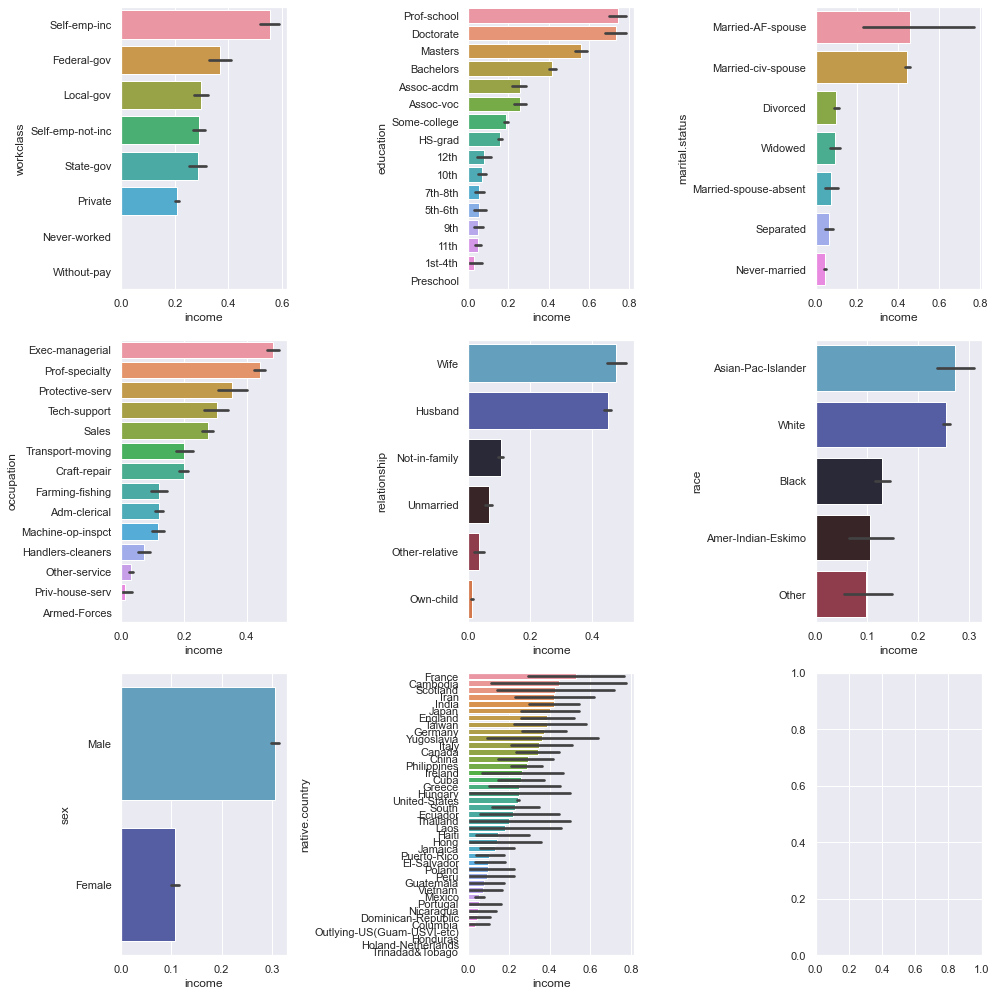

In [36]:
import math
f,ax = plt.subplots(3,3,figsize=(14,14))

for n,i in enumerate(cat_feat):
    art_f=sns.barplot(data=train,y=i,x='income',orient='h'
                        ,order = train.groupby(i).mean()['income'].sort_values(ascending=False).index
                        ,ax=ax[math.floor(n/3),n%3]);
plt.tight_layout()

In [39]:
train['workclass'].value_counts().index

Index(['Private', 'Self-emp-not-inc', 'Local-gov', 'State-gov', 'Self-emp-inc',
       'Federal-gov', 'Without-pay', 'Never-worked'],
      dtype='object')

In [40]:
train.groupby('workclass').mean()['income'].sort_values(ascending=False).index

Index(['Self-emp-inc', 'Federal-gov', 'Local-gov', 'Self-emp-not-inc',
       'State-gov', 'Private', 'Never-worked', 'Without-pay'],
      dtype='object', name='workclass')

From above:
* In general, Asian and White races present the highest proportion of high salaries
* The self-emp-inc is the only workclass over 0.5, followed by Federal-gov. Private has the lower ratio.
* Bachelors is effectively a break point in the trend.
* There is a substantial difference between the top 5 occupations and the rest
* European and Asian countries have higher salary ratio than the United States

# 5.Feature Engineering

In [39]:
from sklearn.preprocessing import FunctionTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder # OHE is commonly used for linear models
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

### Approach

As we mention at the beginning of the notebook, instead of predefining the preprocessing strategy directly from the patterns we discovered, such as those related to married people or race, we will test different encoders and feature selection strategies alongside the different models in the same **pipeline**, this way we avoid data leakage and automate the tasks.

**There is no free lunch!** we need to test many models and data processing combinations, as there is no universally best performance method for all problems.

## 5.1 Base Feature Engineering

### Skewness

Let's begin tackling the **skewness** we observed previously. To do this, we will try a log transformation:

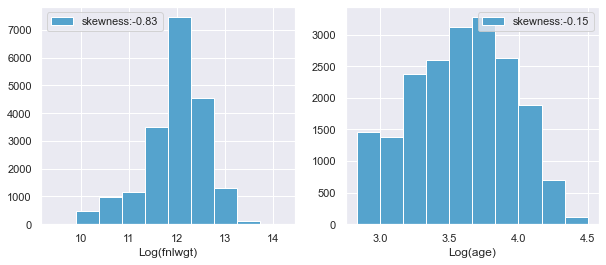

In [40]:
sk_fnl=np.log(train['fnlwgt']).skew()
sk_age=np.log(train['age']).skew()

f, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].hist(np.log(train['fnlwgt']),label=f'skewness:{sk_fnl:.2f}')
ax[0].legend()
ax[0].set_xlabel('Log(fnlwgt)')
np.log(train['age']).hist(ax=ax[1],label=f'skewness:{sk_age:.2f}')
ax[1].legend()
ax[1].set_xlabel('Log(age)');

As we can notice, log transformation was effective and corrected the skewness of the feature 'age' and greatly moderates the asymmetry of 'fnlwgy'. Therefore, we will include this transformation in our preprocessing steps.

### Sex & education

Before trying models and encoders we will transform "sex" to a binary feature and use ordinal encoder on "education", since we can define a logical order for different levels of education. From the EDA we could identify that people below HS have the lowest salary ratio, so we will group them and then we will order the feature, starting with people with unfinished HS and ending with Doctorate degree.

### Native Country

The last feature we will interevene corresponds to native.country, in this case we will drop it. The decision of dropping the whole feature is based on 2 criterias:

* The feature was evaluated in the feature selection section (later section), resulting in poor importance for the model (evaluated via OHE encoding and via target encoding).

* In addition to being unimportant, its high cardinality greatly increases the dimensionality, bringing with it slow computation processes and fitting noise.

comment: we could have encoded the feature according to our knowledge from EDA, such as using the continent or a method alike, but for simplicity we will simply remove the column

In [42]:
# sex & education will be encoded ordinally, so they won't be in the list of features to encode. native.country will be dropped
enc_col = census.select_dtypes(include=object).drop(['sex', 'education', 'native.country'],axis=1).columns

# education feature
undergrad = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th']    # grouping people under-HS
education_order = ['HS-undergrad','HS-grad','Some-college','Assoc-acdm'
                     ,'Assoc-voc','Bachelors','Masters','Prof-school','Doctorate']    # defines the cat order

## 5.2 Pipeline structure

In [43]:
# Features Preprocessing
col_transf = ColumnTransformer([('drop_native.c', 'drop',['native.country'])
                                ,('OE',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['sex'])  # transforming sex into 0-1 binary feature
                                ,('sub_pipe_ed',Pipeline([
                                     ('group_ed', FunctionTransformer(lambda series: series.replace(undergrad,'HS-undergrad'), validate=False))  # grouping people whose education is below HS 
                                    ,('encoder_ed',OrdinalEncoder(categories=[education_order],handle_unknown='use_encoded_value',unknown_value=-1))  # ordindal educational level
                                        ]), ['education']
                                     )
                                ,('encoder','passthrough', enc_col)    # columns to encode #base_enc
                                ,('skew',FunctionTransformer(np.log1p),['age','fnlwgt'])  # tackling num features skewness
                                   ]   
                                ,remainder='passthrough'
                                ,n_jobs=-1
                                )


# Final Pipeline, fits the model
pipe = Pipeline([('col_transf',col_transf)
                ,('scaler',StandardScaler())
                ,('feature_select','passthrough')
                ,('model','passthrough')]
               )


# Although we know that tree based methods are not sensitive to scaling, this process is still included in the pipeline.
# Tree based methods are not sensitive to scaling since they only need to find "cut points" to split nodes.

In [1]:
# Let's take a look at our pipeline

# from sklearn import set_config
# set_config(display='diagram')
# display(pipe)

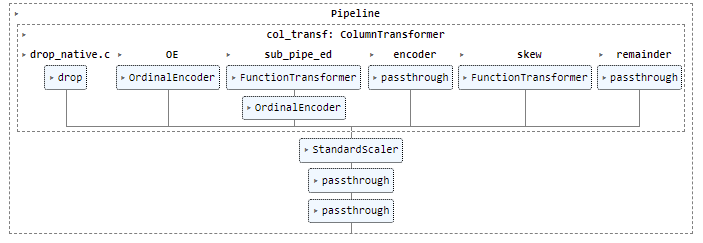

## 5.3 Testing Classifier-Encoder combinations

To test the different combinations we will use models without Hyperparameter optimization & Gridsearch cross validation with 5 folds, selecting those with the highest scores.

### Evaluation Metric

In this project the dataset in not highly imbalanced and we are equally interested in both categories, thus **ROC AUC and accuracy** are the selected metrics of interest, being Roc Auc the metric selected to optimize our models since it will give us different scenarios depending on the threshold (something useful with a mildly imbalanced dataset).

it is worth noting that roughly 75% is classified as people earning less than 50k, so this will be our base accuracy score (classifying all instances as below 50k, or "0", would give us 75% accuracy),therefore the final accuracy of the model should be higher than that.

### Encoder types

For the non transformed categorical features, 6 encoding techniques will be tested:

1. M-estimate (bayesian-encoder)
2. Catboost (bayesian-encoder)
3. James-Stein (bayesian-encoder)
4. Binary (nominal-encoder)
5. OrdinalEncoder 
6. OHE - OneHotEncoder (nominal-encoder)

Two considerations:

* OrdinalEncoder: it might seem pointless to encode a feature that has no order, but it could yield good results for tree based methods, since these only look for cut points to split, and this way is a comprehensive way for the tree to evaluate the feature.


* OHE: it creates several columns and returns a sparse matrix, vital to avoid memory issues. Sparse matrices can't be mean centered by StandardScaler, therefore we will evaluate OHE using gridsearch without mean centering the features. On the other hand, we won't explore the result of dropping redundant columns, this is because we can't set OneHotEncoder to drop the redundant column and handle unknown categories at the same time. In adition to that, regularization & feature selection solve the multicollinearity problem (multicollinearity is only a problem in OLS, regularization solves this).

### Classifier types

We are going to try 4 different models in this project, 2 linear based and 2 tree based (bagging & boosting implementation) models:

1. Logistic Regression
2. SVC (linear) - (RBF or poly kernels are not selected this time due to time complexity)
3. Random Forest
4. XGBClassifier (using tree estimator)

In [45]:
# Encoders
grid_encod = [ce.MEstimateEncoder()
             ,ce.CatBoostEncoder()
             ,ce.JamesSteinEncoder(model='binary')
             ,ce.BinaryEncoder()
             ,OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
             ]

# Models
grid_models = [LogisticRegression(max_iter=1000)
               ,SVC(kernel='linear')  # LinearSVC is faster but it regularizes the bias term (SVC() doesn't). Mean centering the data would address this, but it's a problem with sparse matrices.
               ,RandomForestClassifier(random_state=123)
               ,XGBClassifier(booster='gbtree'
                             ,objective='binary:logistic'
                             ,n_estimators=60
                             ,random_state=1234
                             ,scale_pos_weight=0.75/0.25    # imbalance approx
                             ,use_label_encoder=False
                             )
              ] 

# General parameters for gridsearch
params = {'col_transf__encoder':grid_encod
         ,'model':grid_models}

# Particular combination, try OHE with mean scale = False
# Not centering the data won't affect the algorithms since the regularization methods applyied don't penalize the bias term
# we are still std_scaling, since we need to perform this on continuous features and won't affect much ohe encoded cols (it even may help, when it comes to regularization)
ohe_params = {'col_transf__encoder':[OneHotEncoder(handle_unknown='ignore')]
             ,'scaler':[StandardScaler(with_mean=False)] 
             }

# 2 sets of params for gridsearch, the main & the OHE special case
grid_params = [params,{**params, **ohe_params}]

# given that the dataset is mildly imbalanced, we use roc_auc as scoring parameter. 
# for higlhy imbalanced datasets we would prefere aucpr since this turns the attention to the positive (less common) class.
grid = GridSearchCV(pipe, param_grid=grid_params, scoring='roc_auc',cv=5,n_jobs=-1)

grid.fit(train.drop('income',axis=1), train['income']);

[19:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [46]:
pd.DataFrame(grid.cv_results_)[['param_col_transf__encoder','param_model','mean_test_score']]\
    .sort_values('mean_test_score',ascending=False).reset_index(drop=True)

,param_col_transf__encoder,param_model,mean_test_score
0,OneHotEncoder(handle_unknown='ignore'),"XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=60, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=1234, reg_alpha=None,\n reg_lambda=None, scale_pos_weight=3.0, subsample=None,\n tree_method=None, use_label_encoder=False,\n validate_parameters=None, verbosity=None)",0.925987
1,JamesSteinEncoder(model='binary'),"XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=60, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=1234, reg_alpha=None,\n reg_lambda=None, scale_pos_weight=3.0, subsample=None,\n tree_method=None, use_label_encoder=False,\n validate_parameters=None, verbosity=None)",0.923796
2,BinaryEncoder(),"XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=60, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=1234, reg_alpha=None,\n reg_lambda=None, scale_pos_weight=3.0, subsample=None,\n tree_method=None, use_label_encoder=False,\n validate_parameters=None, verbosity=None)",0.923491
3,"OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)","XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=60, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=1234, reg_alpha=None,\n reg_lambda=None, scale_pos_weight=3.0, subsample=None,\n tree_method=None, use_label_encoder=False,\n validate_parameters=None, verbosity=None)",0.923477
4,MEstimateEncoder(),"XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=60, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=1234, reg_alpha=None,\n reg_lambda=None, scale_pos_weight=3.0, subsample=None,\n tree_method=None, use_label_encoder=False,\n validate_parameters=None, verbosity=None)",0.923068
5,CatBoostEncoder(),"XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None,\n enable_categorical=False, gamma=None, gpu_id=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=60, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=1234, reg_alpha=None,\n reg_lambda=None, scale_pos_weight=3.0, subsample=None,\n tree_method=None, use_label_encoder=False,\n validate_parameters=None, verbosity=None)",0.921220
6,CatBoostEncoder(),RandomFo

### Model-encoding selection

From the grid search above, we will select the model-encoder combinations with the highest mean test scores. In the particular case of **XGBClassifier, we will select the second best score (JamesStein encoding)**, this is because OHE is not the best choise for tree-based methods (OHE is popular in the context of linear regressions), as the dummy features will be highly unbalanced, this will affect the information gain (entropy reduction), resulting in low chances to select these dummys with respect to other predictors. In addition to that, we will end up with lower dimensionality, having a faster split search in each trees, faster feature selection and avoid the curse of dimensionality.

1. Log Reg - OHE
2. SVC - OHE
3. RF - Catboost enc
4. XGBClassifier - JamesStein enc

In [47]:
#function to show gridsearch scores

def top_grid(clf):
    clf_df = pd.DataFrame(clf.cv_results_)[['params','mean_test_score','std_test_score']].sort_values('mean_test_score',ascending=False)
    return clf_df

### Catboost encoder regularization

Catboost might produce data leakage given that it uses the prior probability from the training data. To overcome this, besides its method based on "artificial time", we can add an additive smoothing term and gaussian noise. To select the best regularization terms we are performing CV.

In [48]:
catb_grid = [ce.CatBoostEncoder(a=alp,sigma=sig,random_state=1) for alp in [1,5,10,25] for sig in [0, 0.05, 0.1]]

catb_params={'model':[RandomForestClassifier(random_state=123)]
            ,'col_transf__encoder':catb_grid}

c_grid = GridSearchCV(pipe, param_grid=catb_params, cv=5, scoring='roc_auc',n_jobs=-1)
c_grid.fit(train.drop('income',axis=1), train['income']);

In [49]:
top_grid(c_grid).head(1)

,params,mean_test_score,std_test_score
5,"{'col_transf__encoder': CatBoostEncoder(a=5, random_state=1, sigma=0.1), 'model': RandomForestClassifier(random_state=123)}",0.913921,0.006883


Therefore, for the RF model, we select catboost encoder with alpha (a) equal to 5 and sigma (gaussian std noise) equal to 0.1

### JamesStein encoder regularization

JamesStein encoder can also produce data leakage and also allows a sigma value to be passed (need randomized parameter = True to apply the noise).

In [50]:
js_grid = [ce.JamesSteinEncoder(model='binary',randomized=True,sigma=sig,random_state=1) for sig in [0.025,0.05,0.075,0.1,0.15]]

jenco_params = {'model':[XGBClassifier(booster='gbtree'
                             ,objective='binary:logistic'
                             ,n_estimators=60
                             ,random_state=1234
                             ,scale_pos_weight=0.75/0.25
                             ,use_label_encoder=False
                             )]
                ,'col_transf__encoder':js_grid}

j_grid = GridSearchCV(pipe, param_grid=jenco_params, cv=5, scoring='roc_auc', n_jobs=-1)
j_grid.fit(train.drop('income',axis=1), train['income']);

[19:52:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [51]:
top_grid(j_grid).head(1)

,params,mean_test_score,std_test_score
1,"{'col_transf__encoder': JamesSteinEncoder(model='binary', random_state=1, randomized=True), 'model': XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, enable_categorical=False, gamma=None, gpu_id=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_delta_step=None, max_depth=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=60, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=1234, reg_alpha=None, reg_lambda=None, scale_pos_weight=3.0, subsample=None, tree_method=None, use_label_encoder=False, validate_parameters=None, verbosity=None)}",0.923742,0.006714


Therefore, for the XGBClassifier model, we select JamesStein encoder with sigma equal to 0.05 (default)

## 5.4 Feature Selection

For simplicity, we will perform feature selection on 2 different datasets, one with OHE (linear models) and the other with catboost encoding (tree-based models)

To perform feature selection, we will try 3 different strategies from 3 supervised approaches.

1. **Filter based**-Univariate feature selection: 
    1. Mutual information (Information Gain) - Entropy reduction / (non-parametric method)


2. **Wrapper based**-Selection search problem:
    1. Recursive Feature Elimination (RFE)


3. **Embedded**-Part of an algorithm:
    1. Permutation importance (only for tree based methods in this project, comment 2)
    

**Comment 1**: Since mutual information is based on entropy reduction, one would think that it yields similiar results to tree based methods (an it could), but the way it works is different, it is an univariate test that is based on knn distance (non-parametric). So, since there is no free lunch and we have time, we will test all the feature selection methods listed above.

**Comment 2**: The **impurity-based feature importances** ,computed on tree-based models, suffer from **two flaws** that can lead to misleading conclusions. First, they are computed on statistics derived from the **training dataset** and therefore do not necessarily inform us on which features are most important to make good predictions on held-out dataset. Secondly, they **favor high cardinality features, that is features with many unique values (and continuous over categorical)**."

In [52]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif  # Filter (univariate)
from sklearn.feature_selection import RFECV                # Wrapper
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.ensemble import ExtraTreesClassifier

# Display pipelines as plain text again (instead of img)
set_config(display='text')

We used a columntransformer to preprocess our data, so we need to re order our features according to the order we passed them in:

In [53]:
feat_names =['sex'
             ,'education'
             ,*enc_col    # nominal encoded cols
             ,*num_feat]  # num cols

### 5.4.1 OHE encoded Dataset - Linear model Feat. selection

In a common project, one would **avoid one hot encoding features with many categories**, but since we are interested in experimenting, and being this an oportunity to deal with sparce matrices, we will go ahead with this method anyway.

In [54]:
ohe_p = {'col_transf__encoder':OneHotEncoder(handle_unknown='ignore')
        ,'scaler':StandardScaler(with_mean=False) 
        }

pipe.set_params(**ohe_p)

train_ohe = pipe.fit_transform(train.drop('income',axis=1), train['income'])

# we need another feat names since ohe creates many new dummies
ohe_feat_names = ['sex'
                 ,'education'
                 ,*pipe.named_steps['col_transf'].named_transformers_['encoder'].get_feature_names(enc_col)
                 ,*num_feat]

#### Mutual information - Information Gain

In this case we have a sparse matrix with categorical and continuous features, to use mutual information we will need to split the dataset into continuous and discretes features.

In [55]:
# manipulate sparse row matrix as a sparse column matrix
from scipy.sparse import csc_matrix


# discrete - Sparse Matrix
# discrete features in our dataset = sex, education, OHE dummys & education.num
discr_feat = np.hstack((np.arange(0,len(ohe_feat_names)-6),len(ohe_feat_names)-4))

train_ohe_discr = train_ohe.tocsc()[:,discr_feat]
discr_ohe_feat_names = np.array(ohe_feat_names)[discr_feat]



cont_feat = np.hstack((np.arange(len(ohe_feat_names)-6,len(ohe_feat_names)-4)
                        ,np.arange(len(ohe_feat_names)-3,len(ohe_feat_names))
                       ))

# continuous - dataframe
train_ohe_cont = train_ohe.tocsc()[:,cont_feat]
cont_ohe_feat_names = np.array(ohe_feat_names)[cont_feat]
train_ohe_cont = pd.DataFrame(train_ohe_cont.todense(),columns=cont_ohe_feat_names)

#### Mutual information - DISCRETE

In [56]:
#since we cant pass the 'discrete_feature' param into the pipe, we create our custom func
def mutual_info_ohe_discr(x,y):
        return mutual_info_classif(x,y
                                   ,discrete_features=True
                                   ,random_state=123)

discr_ohe_mi_feat = [SelectKBest(score_func=mutual_info_ohe_discr,k=i) for i in range(5,21)]  # select btwn 5-20 feat 

discr_ohe_mi_params = {'col_transf':['passthrough'],'scaler':['passthrough']
              ,'feature_select':discr_ohe_mi_feat
              ,'model':[LogisticRegression(penalty='l1',solver='liblinear')]
               }

discr_ohe_mi_grid = GridSearchCV(pipe, param_grid=discr_ohe_mi_params, cv=4, scoring='roc_auc',n_jobs=-1,error_score='raise')
discr_ohe_mi_grid.fit(train_ohe_discr, train['income']);

In [57]:
# feat importance df
discr_ohe_mi_scores = pd.DataFrame(zip(discr_ohe_feat_names,discr_ohe_mi_grid.best_estimator_.named_steps['feature_select'].scores_)\
                            , columns=['feature','mi_score']).sort_values('mi_score', ascending = False)

# feat number df
discr_ohe_mi_df = pd.DataFrame(zip(np.arange(5,25),pd.DataFrame(discr_ohe_mi_grid.cv_results_)['mean_test_score'].tolist())\
                    ,columns=['num_feat','mean_score'])

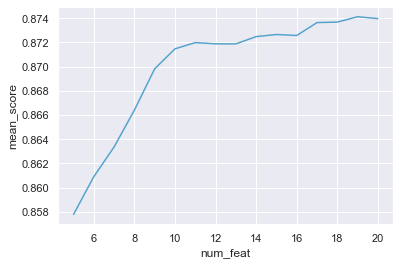

In [58]:
sns.lineplot(data=discr_ohe_mi_df,x='num_feat',y='mean_score');

We can see that after 10 features, we are not adding as much value to the prediction score with each new feature

#### Mutual information - CONTINUOUS

In [59]:
#since we cant pass the 'discrete_feature' param into the pipe, we create our custom func
def mutual_info_ohe_cont(x,y):
        return mutual_info_classif(x,y
                                   ,discrete_features=False
                                   ,random_state=123)

cont_ohe_mi_feat = [SelectKBest(score_func=mutual_info_ohe_cont,k=i) for i in range(2,6)]
 
cont_ohe_mi_params = {'col_transf':['passthrough'],'scaler':['passthrough']
              ,'feature_select':cont_ohe_mi_feat
              ,'model':[LogisticRegression(penalty='l1',solver='liblinear',max_iter=300)]
               }

cont_ohe_mi_grid = GridSearchCV(pipe, param_grid=cont_ohe_mi_params, cv=5, scoring='roc_auc',n_jobs=-1,error_score='raise')
cont_ohe_mi_grid.fit(train_ohe_cont, train['income']);

In [60]:
# feat importance df
cont_ohe_mi_scores = pd.DataFrame(zip(cont_ohe_feat_names,cont_ohe_mi_grid.best_estimator_.named_steps['feature_select'].scores_)\
                            , columns=['feature','mi_score']).sort_values('mi_score', ascending = False)

# feat number df
cont_ohe_mi_df = pd.DataFrame(zip(np.arange(2,6),pd.DataFrame(cont_ohe_mi_grid.cv_results_)['mean_test_score'].tolist())\
                    ,columns=['num_feat','mean_score'])

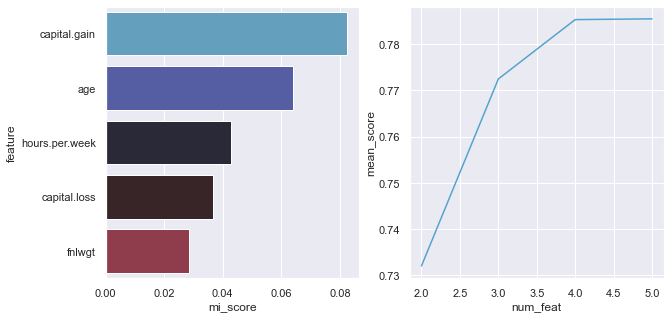

In [61]:
f, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(data=cont_ohe_mi_scores, x='mi_score', y='feature', ax=ax[0])
sns.lineplot(data=cont_ohe_mi_df, x='num_feat',y='mean_score',ax=ax[1]);

In this case, we see that fnlwgt doesn't improve the score, and that at least 3 features are relevant, being capital.loss a candidate to leave the model.

#### RFE - Recursive Feature Elimination

In [62]:
# we will wrapp RFE around a linear model (logreg with lasso regularization) 
ohe_rfe_selector = RFECV(estimator=LogisticRegression(penalty='l1',solver='liblinear',max_iter=300)
                     ,scoring='roc_auc'
                     ,cv=4
                     ,step=1
                     ,min_features_to_select=5
                     ,n_jobs=-1)

ohe_rfe_selector.fit(train_ohe, train['income']);

In [63]:
# feat importance df
ohe_rfe_df = pd.DataFrame(zip(np.arange(5,48),ohe_rfe_selector.cv_results_['mean_test_score'])
                        ,columns=['num_feat','mean_score'])

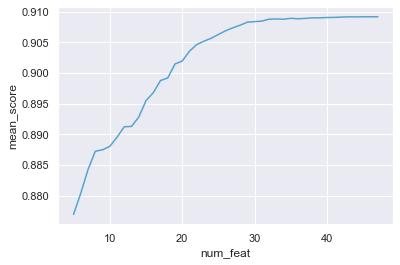

In [64]:
sns.lineplot(data=ohe_rfe_df, x='num_feat',y='mean_score');

In this case, we can see that after 20 features the improvement rate decreases, and therefore, we will select this as the optimal number. Let's apply RFE with 20 features:

In [65]:
ohe_rfe_selector20 = RFE(estimator=LogisticRegression(penalty='l1', solver='liblinear',max_iter=300)
                        ,step=1)

ohe_rfe_params20 = {'n_features_to_select':[20]}

ohe_rfe_grid20 = GridSearchCV(ohe_rfe_selector20, param_grid=ohe_rfe_params20, n_jobs=-1, cv=4, scoring='roc_auc')
ohe_rfe_grid20.fit(train_ohe, train['income']);

In [66]:
# feat importance df
ohe_select_ft_mask = ohe_rfe_grid20.best_estimator_.support_
ohe_select_ft = np.array(ohe_feat_names)[ohe_select_ft_mask]
ohe_logreg_importance = ohe_rfe_grid20.best_estimator_.estimator_.coef_
ohe_rfe_scores = pd.DataFrame(zip(ohe_select_ft,np.abs(ohe_logreg_importance[0]))
                              ,columns=['feature','rfe_score']).sort_values('rfe_score',ascending=False)

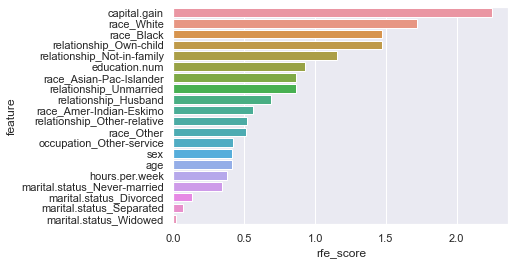

In [67]:
sns.barplot(data=ohe_rfe_scores, x='rfe_score',y='feature');

#### Feature selection - OHE encoded dataset

* Since RFE is an iterative version of embedded methods, we won't apply embedded feature selection method on OHE dataset.

* Based on the previos feature selection methods, we will select a dataset with 20 features.

In [68]:
ohe_feat_selector = RFE(estimator=LogisticRegression(penalty='l1', solver='liblinear',max_iter=300)
                    ,n_features_to_select=20    
                    ,step=1)

ohe_p = {'col_transf__encoder':OneHotEncoder(handle_unknown='ignore')
        ,'scaler':StandardScaler(with_mean=False) 
        ,'feature_select':ohe_feat_selector
        }

pipe.set_params(**ohe_p)


#final dataset for linear models after encoding & Feature selection:
train_ohe_final = pipe.fit_transform(train.drop('income',axis=1), train['income'])

### 5.4.2 Catboost encoded Dataset - Tree based model Feat. selection

For this dataset, we will execute the feature selection methods, store their results, and compare them at the end.

#### Catboost encoded Dataset

In [69]:
pipe.set_params(col_transf__encoder=ce.CatBoostEncoder(a=5,sigma=0.1,random_state=1))
train_catboost = pd.DataFrame(pipe.fit_transform(train.drop('income',axis=1), train['income']),columns=feat_names)

#### Mutual information - Information Gain

In [70]:
#since we cant pass the 'discrete_feature' param into the pipe, we create our custom func
def mutual_info_catb(x,y):
        return mutual_info_classif(x,y
                                   ,discrete_features=[0,1,10] #sex, education & education.num / train_cat.nunique()
                                   ,random_state=123) # n_neighbors didn't change the conclusions

mi_feat = [SelectKBest(score_func=mutual_info_catb,k=i) for i in range(7,14)]

# 
mi_params = {'col_transf':['passthrough'],'scaler':['passthrough']
              ,'feature_select':mi_feat
              ,'model':[RandomForestClassifier(random_state=123,class_weight='balanced_subsample',max_depth=8)]
               }

mi_grid = GridSearchCV(pipe, param_grid=mi_params, cv=5, scoring='roc_auc',n_jobs=-1)
mi_grid.fit(train_catboost, train['income']);

In [71]:
# feat importance df
catb_mi_scores = pd.DataFrame(zip(feat_names,mi_grid.best_estimator_.named_steps['feature_select'].scores_)\
                            , columns=['feature','mi_score']).sort_values('mi_score', ascending = False)
#plt.xticks(rotation=45)

# feat number df
catb_mi_df = pd.DataFrame(zip(np.arange(7,14),pd.DataFrame(mi_grid.cv_results_)['mean_test_score'].tolist())\
                    ,columns=['num_feat','mean_score'])

#### RFE - Recursive Feature Elimination

In [72]:
# we will wrapp RFE around a non-linear model (RF with regularization) 

rfe_selector = RFECV(estimator=RandomForestClassifier(random_state=123, max_depth=8,class_weight='balanced_subsample')
                     ,scoring='roc_auc',n_jobs=-1
                     ,cv=3,step=1,min_features_to_select=7)

rfe_selector.fit(train_catboost, train['income']);

In [73]:
# feat importance df
select_ft_mask = rfe_selector.support_
select_ft = np.array(feat_names)[select_ft_mask]
rf_importance = rfe_selector.estimator_.feature_importances_
catb_rfe_scores = pd.DataFrame(zip(select_ft,rf_importance),columns=['feature','rfe_score'])

# feat importance df
catb_rfe_df = pd.DataFrame(zip(np.arange(7,14),rfe_selector.cv_results_['mean_test_score'])
                        ,columns=['num_feat','mean_score'])

##### Embedded - Permutation Importance

In [75]:
# for permutation importance, we need an already fitted model
permut_imp_et = ExtraTreesClassifier(random_state=123
                                   ,max_depth=8
                                   ,class_weight='balanced_subsample'
                                   ).fit(train_catboost, train['income'])
def permutation_custom(x,y):
    return permutation_importance(permut_imp_et, x, y
                                  ,random_state=123
                                  #,n_jobs=-1
                                  ,n_repeats=4
                                  ,scoring='roc_auc'
                                  )['importances_mean']
    

permut_feat = [SelectKBest(score_func=permutation_custom,k=i) for i in range(7,14)]


permut_params = {'col_transf':['passthrough'],'scaler':['passthrough']
              ,'feature_select':permut_feat
              ,'model':[RandomForestClassifier(random_state=123,class_weight='balanced_subsample',max_depth=8)]
               }

perm_grid = GridSearchCV(pipe, param_grid=permut_params, cv=4, scoring='roc_auc',n_jobs=-1)
perm_grid.fit(train_catboost, train['income']);

In [76]:
# feat importance df
catb_perm_scor = perm_grid.best_estimator_.named_steps['feature_select'].scores_
catb_permut_scores = pd.DataFrame(zip(feat_names,catb_perm_scor),columns=['feature','permut_score']).sort_values('permut_score',ascending=False)

# feat number df
catb_permut_df = pd.DataFrame(zip(np.arange(7,14),pd.DataFrame(perm_grid.cv_results_)['mean_test_score'].tolist())\
                             ,columns=['num_feat','mean_score'])

#### Feature selection - Catboost encoded dataset

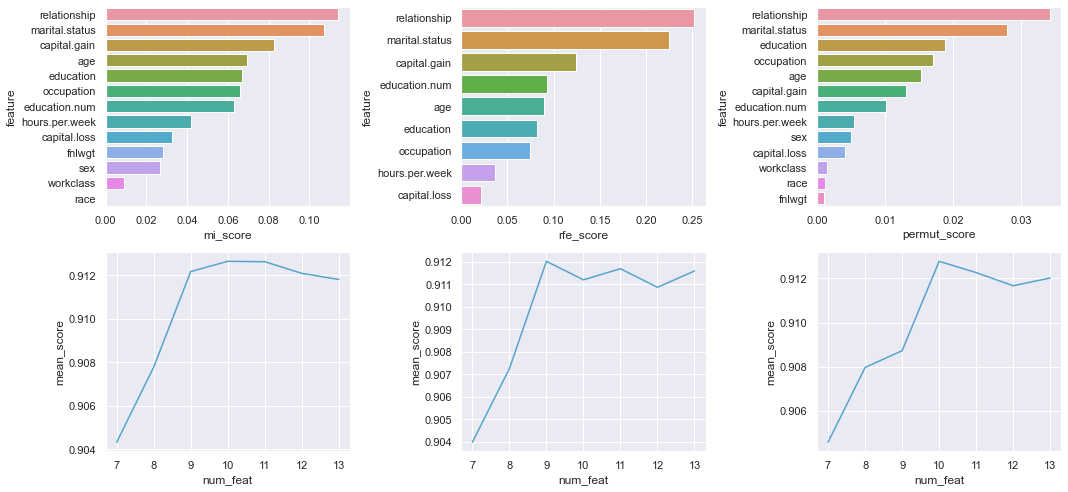

In [77]:
f, ax = plt.subplots(2,3,figsize=(15,7))

# Feture Importance

catb_mi_plot = sns.barplot(data=catb_mi_scores,y='feature',x='mi_score',ax=ax[0,0])
catb_rfe_plot = sns.barplot(data=catb_rfe_scores,y='feature', x='rfe_score'
                           ,order=catb_rfe_scores.sort_values('rfe_score',ascending=False)['feature']
                           ,ax=ax[0,1]);
catb_perm_plot = sns.barplot(data=catb_permut_scores, x='permut_score',y='feature'
                            ,order=catb_permut_scores['feature']
                            ,ax=ax[0,2]);

# Number of Features

catb_num_feat_mi_plot = sns.lineplot(data=catb_mi_df,x='num_feat', y='mean_score',ax=ax[1,0])
catb_num_feat_rfe_plot = sns.lineplot(data=catb_rfe_df,x='num_feat',y='mean_score',ax=ax[1,1])
catb_num_feat_permut_plot = sns.lineplot(data=catb_permut_df,x='num_feat', y='mean_score',ax=ax[1,2])

ax[1,0].set_xticks(range(7,14))
ax[1,1].set_xticks(range(7,14))
ax[1,2].set_xticks(range(7,14))

plt.tight_layout()

From the graphs above, 10 features seems to be a good number among the three features selection methods. Therefore, now we need to drop 3 features based on their importance, these will be:

* race
* fnlwgt
* workclass

comment 1: we will keep capital.loss despite the fact that it contains few non 0s values.

comment 2: It is very interesting to note that **race is not important in this dataset compared to the OHE dataset**, taking a look at this (in adition to EDA) might suggest that the we could transform this feature to extract the determining categories, but for simplicity we will leave the feature selection step up to this point.

In [78]:
# final dataset for tree based models after encoding & Feature selection:

# catboost for Random Forest
train_catboost_final = train_catboost.drop(['race', 'fnlwgt', 'workclass'],axis=1)

# JamesStein for XGB
pipe.set_params(col_transf__encoder=ce.JamesSteinEncoder(model='binary'))
train_jamesstein = pd.DataFrame(pipe.fit_transform(train.drop('income',axis=1), train['income']),columns=feat_names)
train_jamesstein_final = train_jamesstein.drop(['race', 'fnlwgt', 'workclass'],axis=1)

# 6.Training & Hyperparameters Optimization (HPO)

In [79]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import VotingClassifier

## 6.1 Logistic Regression Classifier

In [80]:
log_reg_clf = LogisticRegression(random_state=123, max_iter=300)

c_vals = [0.1,1,10,100]
lr_params1 = {'solver':['liblinear']
            ,'class_weight':[None,'balanced']
            ,'penalty':['l1','l2']
            ,'C':c_vals}

lr_params2 = {'solver':['lbfgs']
            ,'class_weight':[None,'balanced']
             ,'penalty':['l2']
             ,'C':c_vals}

lr_params=[lr_params1,lr_params2]

# since this method takes little time to train, we can use repeated stratified K-fold
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=123)

lr_g_clf = GridSearchCV(log_reg_clf, param_grid=lr_params, cv=rskf, scoring='roc_auc', n_jobs=-1)
lr_g_clf.fit(train_ohe_final, train['income']);

In [81]:
top_grid(lr_g_clf).head(1)

,params,mean_test_score,std_test_score
23,"{'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}",0.899849,0.004668


## 6.2 SVM Classifier (linear)

Many values were tried, but due to time consuption, only the chosen parameters are displayed. We will define the SVM classifier enabling the probability parameter, this will give us an estimated probability through cross-validation (it is not recommended to enable it during gridsearch, it is a very time consuming task).

In [84]:
svm_clf = SVC(kernel='linear',probability=True,random_state=123
             ,class_weight='balanced'
             ,C=750)

## 6.3 Random Forest Classifier

In this case we will use Randomized search since we have many hyperparameters. It is worth noting that some authors, like Bengio and Bergstra, claim that this method is much more efficient that grid search given that we have a 95% of finding a result within the top 5% optimal with only 60 iterations!. 

Providing that each iteration is independent, the probability of having at least one within the top 5% in n iterations is: $1-(1-0.05)^{n}$

Comment: we are just listing some of the parameter tried in the grid search due to time consuption.

In [85]:
rf_clf = RandomForestClassifier(criterion='gini',random_state=123)

rf_g_params={'n_estimators':[200]
            ,'max_depth':np.arange(8,15)
            ,'max_features':['auto',0.5,1.0]
            ,'class_weight':[None,'balanced','balanced_subsample']
            }


rf_g_clf=RandomizedSearchCV(rf_clf, param_distributions=rf_g_params,n_iter=60
                            , scoring='roc_auc', cv=5
                            ,random_state=123,n_jobs=-1)

rf_g_clf.fit(train_catboost_final, train['income']);

In [86]:
top_grid(rf_g_clf).head(1)

,params,mean_test_score,std_test_score
48,"{'n_estimators': 200, 'max_features': 'auto', 'max_depth': 11, 'class_weight': None}",0.915015,0.007062


## 6.4 XGBoost Classifier

Since we are taking advantage of early stopping, we will split your training dataset to evaluate when to stop based on the hold out data.

In [87]:
sssplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

split_df = pd.concat((train_jamesstein_final,train[['income']].reset_index(drop=True)),axis=1)

for train_idx, test_idx in sssplit.split(split_df, split_df['income']):
    test_xgb = split_df.loc[test_idx]
    train_xgb = split_df.loc[train_idx]

In addition to that, this is a complex algorithm with many hyperparameters we followeda 4 step procedure:
 1. Fixed high learning rate (0.05-0.3)
 2. Tune tree specific parameters
 3. Tune Regularizaton parameters
 4. Lower the learning rate

The values below are the ones chosen after this:

In [90]:
xgb_clf = XGBClassifier(objective='binary:logistic'
                       ,booster='gbtree'
                       ,random_state=123
                       ,scale_pos_weight=0.75/0.25
                       ,use_label_encoder=False
                       ,n_estimators=5000
                       )

xgb_grid_params = {'max_depth':[3]
               ,'learning_rate':[0.05]
               ,'min_child_weight':[0]
               ,'gamma':[0.4]
               ,'subsample':[1]
               ,'reg_lambda':[1]        # Ridge over lasso since we performed feature selection
               }


fit_params = {'early_stopping_rounds':40
             ,'eval_metric':'auc'
             ,'eval_set':[[test_xgb.drop('income',axis=1), test_xgb['income']]]
             ,'verbose':0}

xgb_g_clf = GridSearchCV(xgb_clf, param_grid=xgb_grid_params,cv=5,scoring='roc_auc',n_jobs=-1)
xgb_g_clf.fit(train_xgb.drop('income',axis=1), train_xgb['income'], **fit_params);

In [91]:
top_grid(xgb_g_clf)

,params,mean_test_score,std_test_score
0,"{'gamma': 0.4, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0, 'reg_lambda': 1, 'subsample': 1}",0.927978,0.003209


## 6.5 Final Models Pipelines

In [92]:
# 1. Log Reg
lr_pipe = Pipeline([('col_transf',col_transf)
                     ,('scaler',StandardScaler(with_mean=False))
                     ,('feature_select',ohe_feat_selector)
                     ,('model',lr_g_clf.best_estimator_)]
                    )
lr_pipe.set_params(col_transf__encoder=OneHotEncoder(handle_unknown='ignore'))                    

# 2. SVM
svm_pipe = Pipeline([('col_transf',col_transf)
                     ,('scaler',StandardScaler(with_mean=False))
                     ,('feature_select',ohe_feat_selector)
                     ,('model',svm_clf)]
                    )
svm_pipe.set_params(col_transf__encoder=OneHotEncoder(handle_unknown='ignore'))                    

# 3. Random Forest                              
rf_pipe = Pipeline([('col_transf',col_transf)
                 ,('scaler',StandardScaler())
                 ,('to_dataframe',FunctionTransformer(lambda x: pd.DataFrame(x,columns=feat_names)))
                 ,('feature_select',ColumnTransformer([
                                        ('drop_cols','drop',['fnlwgt','race','workclass'])]
                                         ,remainder='passthrough')
                                    )
                 ,('model',rf_g_clf.best_estimator_)]
                )
rf_pipe.set_params(col_transf__encoder=ce.CatBoostEncoder(a=5,sigma=0.1,random_state=1))

# 4. XGB Classifier                             
xgb_pipe = Pipeline([('col_transf',col_transf)
                 ,('scaler',StandardScaler())
                 ,('to_dataframe',FunctionTransformer(lambda x: pd.DataFrame(x,columns=feat_names)))
                 ,('feature_select',ColumnTransformer([
                                         ('drop_cols','drop',['fnlwgt','race','workclass'])]
                                         ,remainder='passthrough')
                                     )
                 ,('model',xgb_g_clf.best_estimator_)]
                )
xgb_pipe.set_params(col_transf__encoder=ce.JamesSteinEncoder(model='binary'));

## 6.6 Soft-Voting Classifier

In order to train a common Voting classifier from 3 differents datasets (depending on the feature eng technique), we need to pass the pipeline from each classifier to the final soft voting classifier.

In [93]:
models = [('lr',lr_pipe)
         ,('svm',svm_pipe)
         ,('rf',rf_pipe)
         ,('xgb',xgb_pipe)]

soft_vote_clf = VotingClassifier(estimators=models, voting='soft', n_jobs=-1)
soft_vote_clf.fit(train.drop('income',1), train['income']);

# 7.Results

In [95]:
for model in [lr_pipe, svm_pipe, rf_pipe, xgb_pipe]:
    model.fit(train.drop('income',axis=1), train['income'])

[21:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 7.1 Classifiers Acuraccy Score

In [96]:
final_score = {'accuracy_score':[lr_pipe.score(test.drop('income',axis=1), test['income'])
                        ,svm_pipe.score(test.drop('income',axis=1), test['income'])
                        ,rf_pipe.score(test.drop('income',axis=1), test['income'])
                        ,xgb_pipe.score(test.drop('income',axis=1), test['income'])
                        ,soft_vote_clf.score(test.drop('income',axis=1), test['income'])
                       ],
               'model':['Log_reg','SVM','RF','XGB','S_vote']}

score_df = pd.DataFrame.from_dict(final_score).sort_values('accuracy_score',ascending=False)

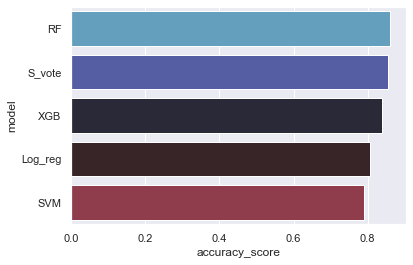

In [97]:
sns.barplot(data=score_df, x='accuracy_score',y='model');

In [98]:
score_df

,accuracy_score,model
2,0.860115,RF
4,0.854050,S_vote
3,0.838541,XGB
0,0.807294,Log_reg
1,0.789942,SVM


We can observe that Random Forest has the best accuracy score with roughly 86%, which is a substantial improvement over our 75% accuracy baseline. On top of that, we can see that our voting classifier is pretty close, and maybe adding more regularization or leaving some models out of it (like SVM) might lead to a better performance.

It is important to note that we optimized our models based on roc auc and this will be our criteria for choosing the final model. Roc auc is prefered in this project because we get a broader view of the models performance given different tresholds, which is especially useful as we have a moderatly unbalanced dataset in this scenario.

## 7.2 ROC AUC

In [99]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

''

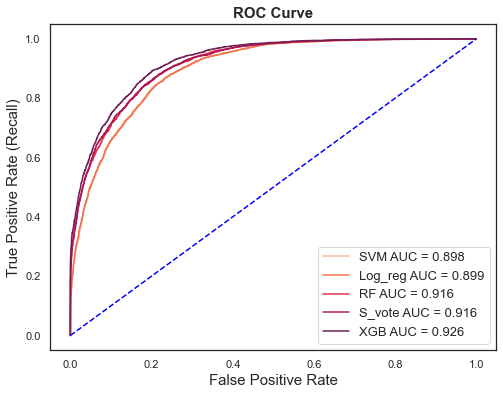

In [100]:
final_models = [('SVM',svm_pipe),('Log_reg',lr_pipe),('RF',rf_pipe),('S_vote',soft_vote_clf),('XGB',xgb_pipe)]

# Let's change the plot properties for a better visualization
sns.set_theme(context='notebook',style='white',palette='rocket_r')

plt.figure(figsize=(8,6))

for name,model in final_models:
    target_pred = model.predict_proba(test.drop('income',axis=1))[:,1]
    auc_score = roc_auc_score(test['income'],target_pred)
    
    fpr, tpr, _ = roc_curve(test['income'],target_pred,pos_label=1)
    plt.plot(fpr,tpr,label=f'{name} AUC = {auc_score:.3f}')
    
plt.plot([0,1],[0,1],color='b',ls='--')
plt.legend(loc='lower right',fontsize=13)

plt.title('ROC Curve',fontsize=15,fontweight='bold')
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate (Recall)',fontsize=15)
;

Finally, from the plot above, we can infer that the classifier with the best performance is the XGB classifier, since it has the higher AUC score, and therefore the one that can achieve the highest recall with the lowest misclassification rate across different thresholds settings.

# 8. Conclusions

In this project we tested many different combinations of feature engenieering techniques, the goal was precisely that, to show  that there are many ways of manipulate the data. Data manipulation is critical to developing good results, and this includes not only applying feature manipulating techniques, but also understanding the context and the models we are using with them, mixing this with cross validation techniques and data pipelines can significantly improve our models, especially since the approach is very practical. 

In a business context this project would also include a deeper description and understanding of the features, ideally with experts, and depending on the business problem, include other metrics or insights relevant to the company or organization.

I hope that this project has served as an example to expose some of the enormous potential of feature engineering.